# Monetary Policy Coordination from Central Bankers' Speeches

## Parameters

In [1]:
project_path = '/content/drive/MyDrive/Monetary Policy Coordination'
# processed data directory inside project_path
data_dir = 'Data/Processed_Data'
# type of randomization algorith used in speech_similarity
rdn_tp = 1

## Initial setup

In [2]:
! pip install netgraph
! pip install kaleido

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append(project_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from netgraph import Graph

from monetary_policy_coordination import speech_similarity

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Some useful functions

In [5]:
def plot_link_distribution(Q, Q_rand, threshold, significance=5):
  qs = []
  qs_rand = []

  for i in range(len(Q)):
    for j in range(len(Q)):
      if i != j:
        qs.append(Q.iloc[i,j])
        qs_rand.append(Q_rand.iloc[i,j])

  hist, _ = np.histogram(Q, density=True)
  hist_rand, _ = np.histogram(Q_rand, density=True)
  y_max = 1.1 * max([hist.max(), hist_rand.max()])

  fig = ff.create_distplot([qs, qs_rand], ['Original Network',
                                           'Randomized Network'],
                          show_hist=False, show_rug=False)
  fig.add_vline(x=threshold, line_width=2, line_dash='dash',
                annotation_text=f'Significance = {significance}%' + \
                                f'<br>q = {threshold:.4f}',
                annotation_align='left')
  fig.update_layout(template='plotly_white', width=600, height=600,
                    legend={'orientation':'h',
                            'yanchor': 'bottom',
                            'y': -0.2,
                            'xanchor': 'center',
                            'x': 0.5,
                            })
  fig.update_xaxes(title='<b>q</b>', range=[0,1], showgrid=False,
                   showline=True, linewidth=2, linecolor='black')
  fig.update_yaxes(title='<b>p</b>', range=[0, y_max], showgrid=False,
                   showline=True, linewidth=2, linecolor='black')
  fig.update_traces(selector={'name': 'Randomized Network'},
                    line={'dash': 'dash'})
  fig.show()

In [6]:
# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html
# https://netgraph.readthedocs.io/en/latest/graph_classes.html#netgraph.Graph
# https://matplotlib.org/stable/users/explain/colors/colormaps.html#grayscale-conversion

def plot_network(graph, central_bank_index):

  G = max(nx.connected_components(graph), key=len)
  G = graph.subgraph(G)

  communities = nx.community.louvain_communities(G, seed=7)
  cmap = plt.cm.viridis.resampled(len(communities))
  community_to_color = {i: cmap(i) for i in range(len(communities))}

  node_to_community = {}
  for i in range(len(communities)):
    node_to_community = {**node_to_community,
                        **{node: i for node in communities[i]}}

  node_color = {node: community_to_color[community_id]
                for node, community_id in node_to_community.items()}

  node_to_central_bank = central_bank_index.loc[list(G.nodes)].to_dict()

  fig, ax = plt.subplots(figsize=(10,10))
  Graph(G,
        node_layout='community',
        node_layout_kwargs=dict(node_to_community=node_to_community),
        node_size=0.8,
        node_edge_width=0,
        node_color=node_color,
        node_alpha=0.8,
        node_labels=node_to_central_bank,
        node_label_fontdict={'size':8},
        edge_width=0.1,
        edge_alpha=0.5,
        edge_layout='bundled',
        scale=(0.5,0.5),
        ax=ax,
  )
  plt.show()

In [7]:
def plot_similarity_evolution(model_results, g10=[]):

  qs = []
  windows = []
  for k, v in model_results.items():
    if g10:
      filter = [cb for cb in g10 if cb in v['Q_filtered'].index]
      q = v['Q_filtered'].loc[filter, filter].to_numpy()
    else:
      q = v['Q_filtered'].to_numpy()
    n = len(q)
    windows.append(k)
    for i in range(n):
      for j in range(n):
        if i != j and q[i,j] != 0:
          qs.append([k, q[i,j]])

  q_df = pd.DataFrame(qs, columns=['window', 'q'])
  mean_series = q_df.groupby('window')['q'].mean()
  q_df['mean_q'] = q_df['window'].map(mean_series)

  sns.set_theme(style='white', rc={"axes.facecolor": (0, 0, 0, 0)})
  pal = sns.cubehelix_palette(len(windows), rot=-.25, light=.7)
  #pal = sns.dark_palette("#69d", reverse=True, n_colors=len(windows))
  #pal = sns.cubehelix_palette(len(windows), start=.5, rot=-.5)
  #pal = sns.color_palette(palette='Blues', n_colors=len(windows))

  g = sns.FacetGrid(q_df, row='window', hue='mean_q', aspect=15,
                    height=0.5, palette=pal)
  g.map(sns.kdeplot, 'q',
        bw_adjust=0.5, clip_on=False,
        fill=True, alpha=1)
  g.map(sns.kdeplot, 'q',
        bw_adjust=0.5, clip_on=False,
        color='white', lw=1)
  g.map(plt.axhline, y=0,
        lw=2, clip_on=False)

  for i, ax in enumerate(g.axes.flat):
      ax.text(0.02, 1, windows[i],
              fontweight='bold', fontsize=10,
              color=ax.lines[-1].get_color())

  g.figure.subplots_adjust(hspace=-0.3)
  g.set_titles('')
  g.set(yticks=[], ylabel='', xlim=(0, 1))
  g.despine(bottom=True, left=True)
  g.set_xticklabels([0,0.2,0.4,0.6,0.8,1])

  plt.setp(ax.get_xticklabels(), fontsize=10, fontweight='bold')
  plt.xlabel('q', fontweight='bold', fontsize=10)

  plt.show()

  return mean_series

In [8]:
# word analysis functions
def show_words_for_cb(model, cb, period=None, matrix='F', head=10):
  """
  Shows the top head terms in matrix for central bank cb.

  matrix can be 'F' or 'N'.

  period=None for first period in the model.
  """
  if not period:
    analysis_period = next(iter(model.period_results))
  df = pd.DataFrame(model.period_results[analysis_period][matrix])
  df = df.rename(columns=dict(model.central_bank_index),
                 index=dict(model.word_index))
  return df.loc[:, cb].sort_values(ascending=False).head(head)

def plot_word_evolution_cb(model, words, cb='', make_title=True):
  """
  Plot the evolution of a set of words for a given central bank.

  cb = '' for every central bank consolidation
  """
  df_word = pd.DataFrame(model.term_central_bank_year)
  df_word = df_word.rename(columns=model.central_bank_index,
                          index=model.word_index,
                          )
  if cb:
    df_words = df_word.loc[words, cb]
    title = cb.title()
  else:
    df_words = df_word.loc[words].T.groupby(level=1).sum().T
    title = 'Overall'
  title_text = title if make_title else None
  print(title)
  fig = (
      px.bar(df_words.T,
             barmode='group',
             title=title_text,
             template='plotly_white')
      .update_xaxes(title='Year')
      .update_yaxes(title='Word Count')
      .update_layout(legend={'title': 'Word'})
  )
  return fig

In [9]:
def plot_word_relation(model,
                       cb,
                       cb_select=0,
                       word_list=[],
                       top_n_words=3,
                       period=None):
  """
  Sankey plot with most important word relations for the selected
  central banks.

  period=None for first period in the model.
  """
  if not period:
    analysis_period = next(iter(model.period_results))
  F = pd.DataFrame(model.period_results[analysis_period]['F'].copy())
  F = F.rename(columns=dict(model.central_bank_index),
               index=dict(model.word_index))
  if not word_list:
    words_idx = list(set(F.loc[:, cb].apply(
        lambda c: c.nlargest(top_n_words).index,axis=0
    ).stack()))
  else:
    words_idx = word_list
  F_relevant = F.loc[words_idx, cb]
  F_relevant = F_relevant.rename(columns=model.central_bank_index,
                                index=model.word_index)
  cb_labels = F_relevant.columns.str.title().to_list()
  word_labels = F_relevant.index.to_list()
  labels = cb_labels + word_labels

  # color ideas from https://timescalefoundation.org/charts/rgb.html
  # cb_colors = px.colors.n_colors('rgb(217, 241, 247)', 'rgb(78, 179, 211)',
  #                                len(cb_labels), colortype='rgb')
  # word_colors = px.colors.n_colors('rgb(230, 245, 225)', 'rgb(51, 169, 126)',
  #                                  len(word_labels), colortype='rgb')

  # from the evolution landscape plot
  # 'rgb(144,193,198)', 'rgb(78,116,147)', 'rgb(31,37,63)'

  def append_opacity(rgb_str, opacity):
    rgb_list = rgb_str.replace('rgb(', '').replace(')','').split(',')
    rgb_list.append(f' {opacity}')
    return f'rgba({",".join(rgb_list)})'

  cb_color = lambda opacity: f'rgba(78, 116, 147, {opacity})'

  # for single color central bank nodes
  cb_colors = [cb_color(0.4)] * len(cb_labels)

  # for color scale central bank nodes
  #cb_colors = px.colors.n_colors('rgb(217, 241, 247)', 'rgb(78, 179, 211)',
  #cb_colors = px.colors.n_colors('rgb(217, 241, 247)', 'rgb(78, 116, 147)',
  #cb_colors = px.colors.n_colors('rgb(78, 179, 211)', 'rgb(78, 116, 147)',
  #cb_colors = px.colors.n_colors('rgb(171, 221, 235)', 'rgb(78, 116, 147)',
  cb_colors = px.colors.n_colors('rgb(194, 231, 241)', 'rgb(78, 116, 147)',
                                len(cb_labels), colortype='rgb')

  # this highlights central bank of interest (cb_select)
  cb_colors = [append_opacity(c, 1) for c in cb_colors]


  #cb_colors[cb_select] = cb_color(1)
  word_colors = ['rgba(78, 116, 147, 0.4)'] * len(word_labels)


  source = []
  target = []
  value = []
  link_colors = []

  for j in range(len(cb_labels)):
    for i in range(len(word_labels)):
      if F_relevant.iloc[i, j] != 0:
        source.append(j)
        target.append(i + len(cb_labels))
        value.append(F_relevant.iloc[i, j])
        link_colors.append(cb_colors[j])

  node = {'pad': 15,
          'thickness':10,
          'label': labels,
          'color':cb_colors + word_colors,
          #'line': {'color': cb_colors + word_colors},
          }

  link = {'source': source,
          'target': target,
          'value':  value,
          'color': link_colors,
          }

  fig = go.Figure(data=go.Sankey(node=node, link=link))
  return fig

In [10]:
# F evolution plots
def plot_F_evolution_cb(model, cb, words, make_title=True):
  df = pd.DataFrame()
  for k, v in model.period_results.items():
    F = v['F'].copy()
    F = F.rename(columns=model.central_bank_index.to_dict(),
                index=model.word_index.to_dict(),
                )
    F = F.loc[:, cb].copy()
    F = F.rename(k)
    df = pd.concat([df, F], axis=1)
  df.columns = df.columns.rename('Period')
  df.index = df.index.rename('Word')
  title_text = cb.title() if make_title else None
  print(cb.title())
  return px.bar(df.loc[words].T,
                barmode='group',
                title=title_text,
                template='plotly_white',
                ).update_yaxes(title='$f^k(w_i)$')

def plot_F_evolution_word(model, cbs, word, make_title=True):
  df = pd.DataFrame()
  for k, v in model.period_results.items():
    F = v['F'].copy()
    F = F.rename(columns=model.central_bank_index.to_dict(),
                index=model.word_index.to_dict(),
                )
    if word not in F.index:
      F = pd.Series(np.nan, index=cbs, name=k)
    else:
      F = F.loc[word, cbs].copy()
      F = F.T.rename(k)
    df = pd.concat([df, F], axis=1)
  df = df.T.rename(columns=lambda x: x.title())
  df.columns = df.columns.rename('Central Bank')
  df.index = df.index.rename('Period')
  title_text =  word if make_title else None
  print(word)
  return px.bar(df,
                barmode='group',
                title=title_text,
                template='plotly_white',
                ).update_layout(legend={
                                'x':0,
                                'xanchor':'left',
                                'y':-0.15,
                                'yanchor':'top',
                                }).update_yaxes(title='$f^k(w_i)$')

In [11]:
# network analysis function
def show_Q_for_cb(model, cb, period=None, head=10):
  """
  Shows the top connections in the network matrix Q for cb

  period=None for first period in the model.
  """
  if not period:
    analysis_period = next(iter(model.period_results))
  df_q = model.period_results[analysis_period]['Q']
  df_q = df_q.rename(columns=model.central_bank_index,
                    index=model.central_bank_index,
                    )
  return df_q.loc[df_q.index != cb,cb].sort_values(ascending=False).head(head)

## Data processing

This step generates the term-document matrix (tdm) from speech data.

We only have to run it once.

In [12]:
# data_manager = speech_similarity(speech_threshold = 100, first_year=1997,
#                                  project_path=project_path,
#                                  data_dir='Data/1_raw_txt')
# data_manager.explore_speech_data()
# data_manager.load_speech_data_to_tdm()
# data_manager.save_tdm(directory=data_dir)

## Treating the entire speech database as one single period

This part does not incorporate coordination changes over time

### Preparation

In [ ]:
# entire database period
y0, y1 = 2002, 2023
period = '-'.join([str(y0), str(y1)])

In [ ]:
model_one_period = speech_similarity(data_dir=data_dir)
model_one_period.load_tdm()

In [ ]:
print(len(model_one_period.term_document.columns), 'speeches')
print(len(model_one_period.term_document.columns.levels[0]), 'institutions')

16842 speeches
41 institutions


In [ ]:
model_one_period.run_single_period(y0, y1, randomize_tp=rdn_tp)

In [ ]:
Q = model_one_period.period_results[period]['Q']
Q_rand = model_one_period.period_results[period]['Q_rand']
threshold = model_one_period.period_results[period]['threshold']
G = model_one_period.period_results[period]['G']
G_filtered = model_one_period.period_results[period]['G_filtered']
central_bank_index = model_one_period.central_bank_index

### Results

In [ ]:
plot_link_distribution(Q, Q_rand, threshold, 5)

/usr/local/lib/python3.10/dist-packages/netgraph/_edge_layout.py:978: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.10/dist-packages/netgraph/_utils.py:360: RuntimeWarning:

invalid value encountered in divide



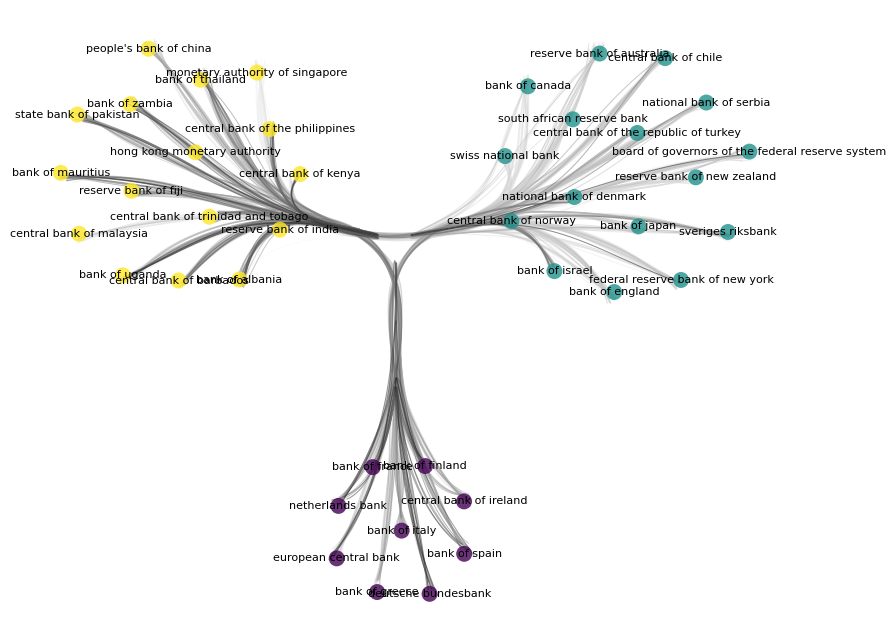

In [ ]:
plot_network(G, central_bank_index)

---

## Moving window speech similarities

Here we will analyse the entire dataset in a moving window manner.

This way we can see how monetary policy coordination evolved throught time.

### Preparation

In [ ]:
model_mov_window = speech_similarity(data_dir=data_dir)
model_mov_window.load_tdm()

In [ ]:
model_mov_window.run_full_study(start=2002, end=2023, interval=2,
                                   step=2, randomize_tp=rdn_tp)

### Results

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.



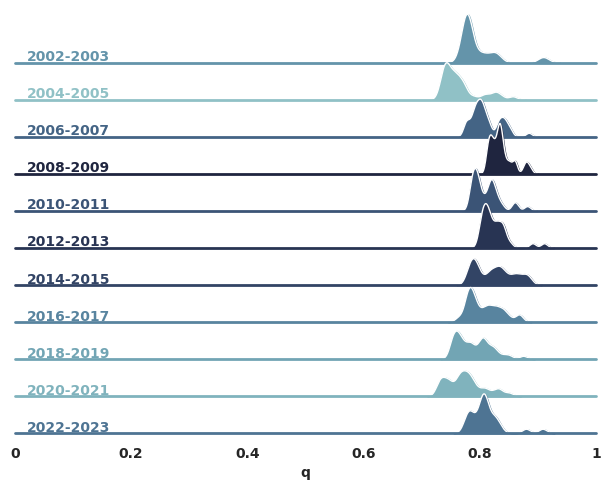

,q
window,
2002-2003,0.797007
2004-2005,0.766593
2006-2007,0.811275
2008-2009,0.837316
2010-2011,0.812470
2012-2013,0.826252
2014-2015,0.825021
2016-2017,0.807895
2018-2019,0.790938


In [ ]:
plot_similarity_evolution(model_mov_window.period_results)

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.



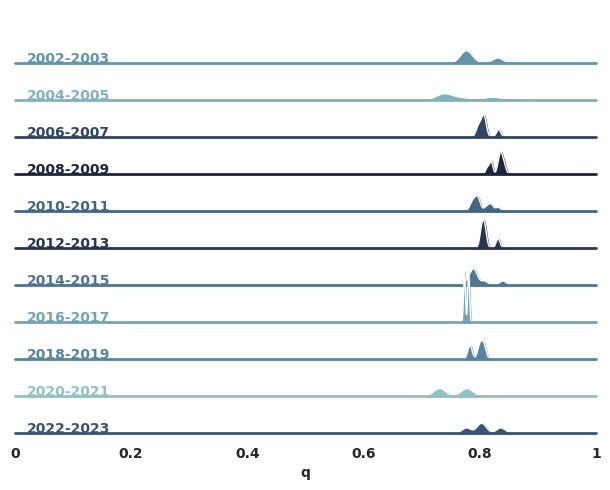

,q
window,
2002-2003,0.790660
2004-2005,0.775359
2006-2007,0.808579
2008-2009,0.830456
2010-2011,0.802684
2012-2013,0.811028
2014-2015,0.798394
2016-2017,0.777185
2018-2019,0.796713


In [ ]:
# evolução somente para G10 a partir da rede completa
g10 = [5, # bank of japan
       0, # european central bank
       7, # reserve bank of australia
       24, # reserve bank of new zealand
       6, # bank of canada
       10, # sveriges riksbank
       15, # swiss national bank
       20, # central bank of norway
       4, # bank of england
       1, # board of governors of the federal reserve system
       ]
plot_similarity_evolution(model_mov_window.period_results, g10)

## Specific periods in the moving window exercise

2008-2009


/usr/local/lib/python3.10/dist-packages/netgraph/_edge_layout.py:978: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.10/dist-packages/netgraph/_utils.py:360: RuntimeWarning:

invalid value encountered in divide



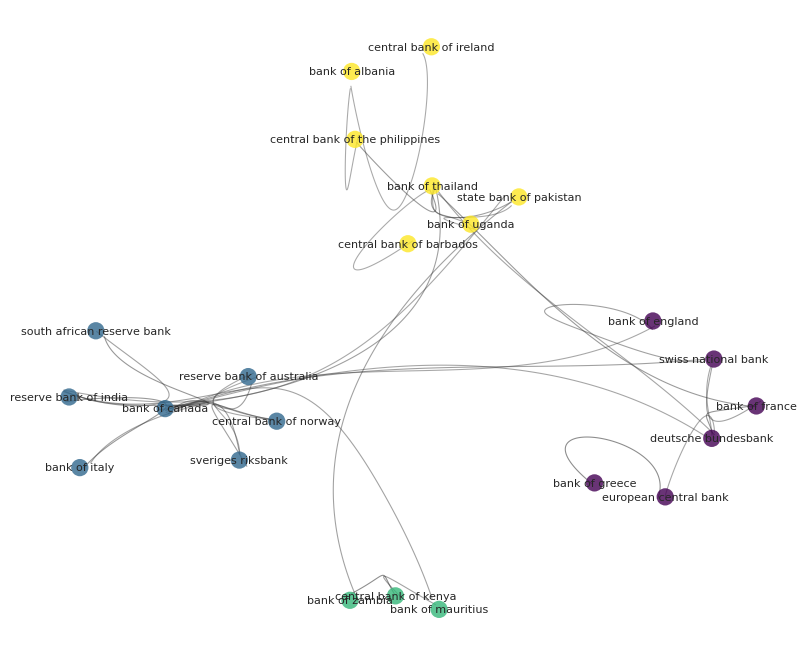



2020-2021


/usr/local/lib/python3.10/dist-packages/netgraph/_edge_layout.py:978: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.10/dist-packages/netgraph/_utils.py:360: RuntimeWarning:

invalid value encountered in divide



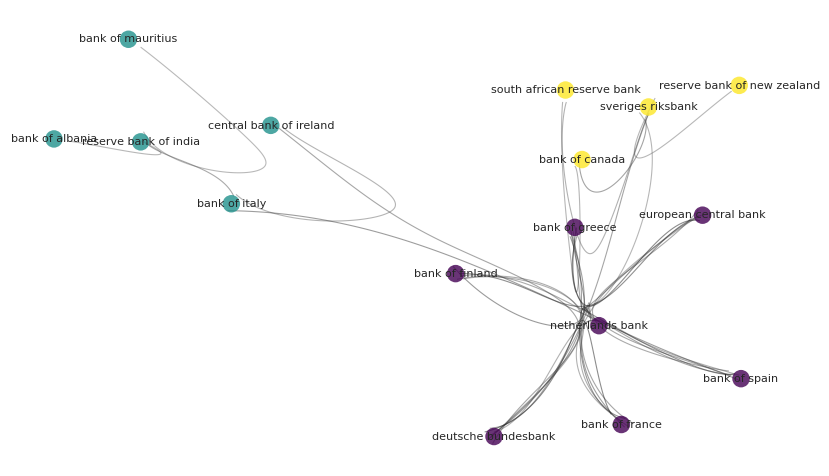



2022-2023


/usr/local/lib/python3.10/dist-packages/netgraph/_edge_layout.py:978: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.10/dist-packages/netgraph/_utils.py:360: RuntimeWarning:

invalid value encountered in divide



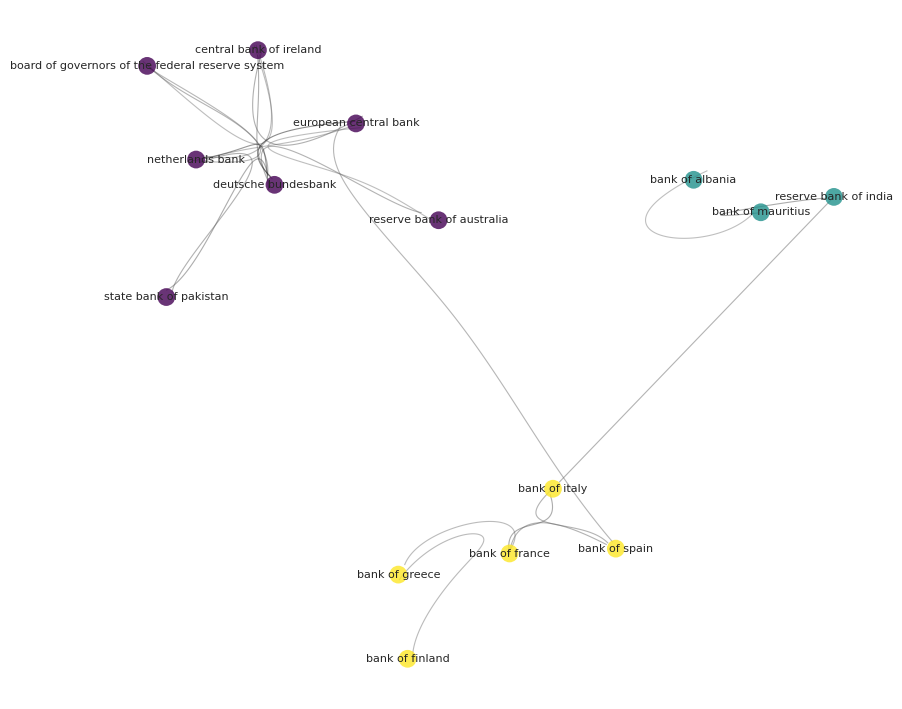

In [ ]:
# max coordination, min coordination and two most recent
#periods = ['1999-2000', '2007-2008', '2021-2022', '2023-2024']
periods = ['2008-2009', '2020-2021', '2022-2023']

central_bank_index_mov_wnd = model_mov_window.central_bank_index
for p in periods:
  print(p)
  Q_p = model_mov_window.period_results[p]['Q']
  Q_rand_p = model_mov_window.period_results[p]['Q_rand']
  threshold_p = model_mov_window.period_results[p]['threshold']
  G_filtered_p = model_mov_window.period_results[p]['G_filtered']

  plot_link_distribution(Q_p, Q_rand_p, threshold_p, 5)
  plot_network(G_filtered_p, central_bank_index_mov_wnd)
  print('\n')

## Pandemic years

In [ ]:
model_pandemic = speech_similarity(data_dir=data_dir)
model_pandemic.load_tdm()

2020-2020


/usr/local/lib/python3.10/dist-packages/netgraph/_edge_layout.py:978: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.10/dist-packages/netgraph/_utils.py:360: RuntimeWarning:

invalid value encountered in divide



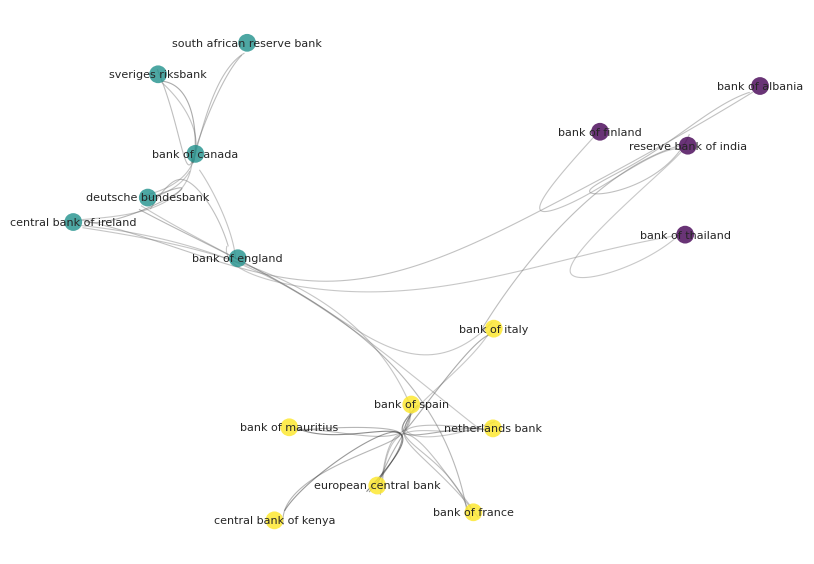



2021-2021


/usr/local/lib/python3.10/dist-packages/netgraph/_edge_layout.py:978: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.10/dist-packages/netgraph/_utils.py:360: RuntimeWarning:

invalid value encountered in divide



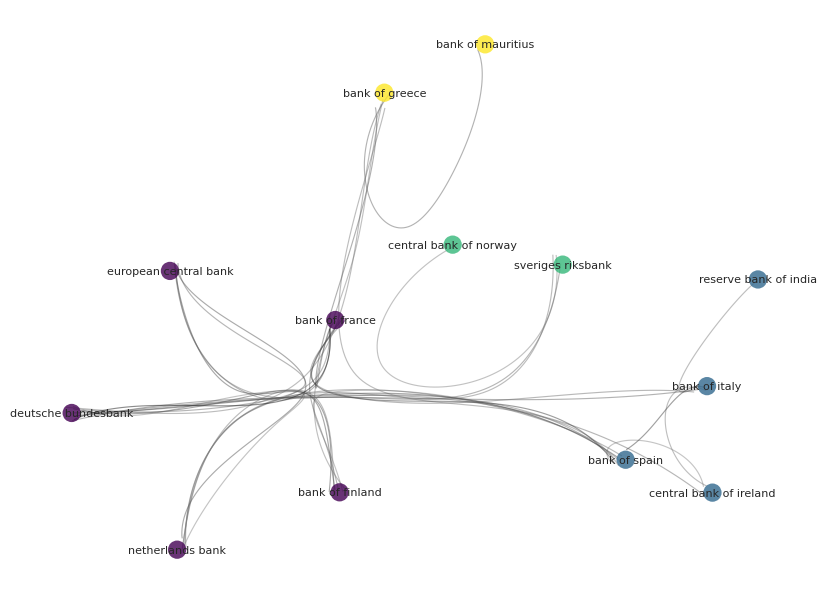



2022-2022


/usr/local/lib/python3.10/dist-packages/netgraph/_edge_layout.py:978: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.10/dist-packages/netgraph/_utils.py:360: RuntimeWarning:

invalid value encountered in divide



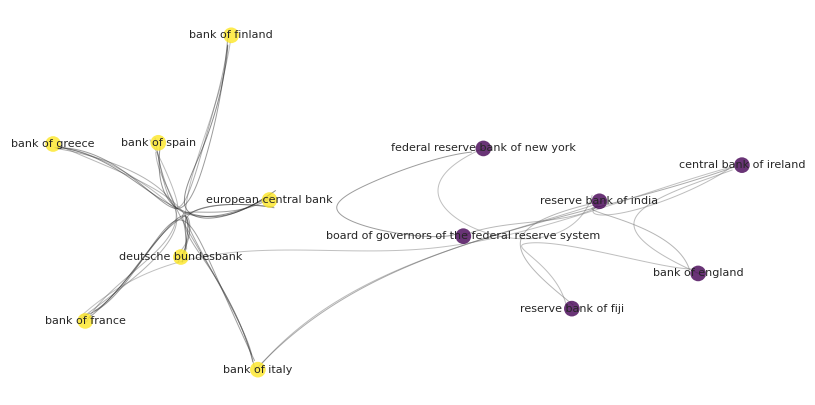

In [ ]:
y_pandemic = [2020, 2021, 2022]

for y_pand in y_pandemic:
  model_pandemic.run_single_period(y_pand, y_pand, randomize_tp=rdn_tp)
  p = '-'.join([str(y_pand)]*2)

  print(p)
  Q_p = model_pandemic.period_results[p]['Q']
  Q_rand_p = model_pandemic.period_results[p]['Q_rand']
  threshold_p = model_pandemic.period_results[p]['threshold']
  G_filtered_p = model_pandemic.period_results[p]['G_filtered']

  plot_link_distribution(Q_p, Q_rand_p, threshold_p, 5)
  plot_network(G_filtered_p, central_bank_index_mov_wnd)
  print('\n')

### Post pandemic year by year evolution

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.



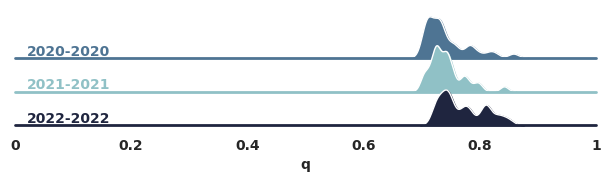

,q
window,
2020-2020,0.743811
2021-2021,0.743516
2022-2022,0.771367


In [ ]:
plot_similarity_evolution(model_pandemic.period_results)

---

## Word Analysis

In [ ]:
# 'european central bank'
# 'bank of england'
# 'board of governors of the federal reserve system'
# 'bank of japan'
show_words_for_cb(model_one_period, 'european central bank', head=50)

,european central bank
euro,0.020278
area,0.014461
ecb,0.013500
bank,0.010859
polici,0.010098
european,0.008481
financi,0.008005
monetari,0.007925
market,0.007824
rate,0.005937


In [ ]:
show_Q_for_cb(model_one_period, 'european central bank')

,european central bank
bank of finland,0.879514
bank of france,0.875670
deutsche bundesbank,0.859533
bank of spain,0.816000
netherlands bank,0.770829
bank of greece,0.749064
national bank of denmark,0.739527
bank of italy,0.683505
central bank of ireland,0.658844
sveriges riksbank,0.629320


In [ ]:
word_list = [#'inflat',
             #'growth',
             #'stabil',
             'crisi',
             #'coordin',
             'pandem',
             #'fiscal',
             #'labour',
             #'labor',
             #'unemploy',
             #'quantit',
             #'consumpt',
             #'output',
             #'shock',
             #'target',
             #'demand',
             #'curv',
             #'employ',
             #'gdp',
             #'price',
             #'risk',
             #'qe',
             'forward',
             'guidanc',
             #'guid',
             #'greenhous',
             ]

plot_word_evolution_cb(model_one_period, word_list, make_title=True)

Overall


In [ ]:
plot_word_evolution_cb(model_one_period,
                       word_list,
                       'european central bank',
                       make_title=True
                       )

European Central Bank


In [ ]:
plot_word_evolution_cb(model_one_period,
                       word_list,
                       'board of governors of the federal reserve system',
                       make_title=True
                       )

Board Of Governors Of The Federal Reserve System


In [ ]:
plot_word_evolution_cb(model_one_period,
                       word_list,
                       'bank of england',
                       make_title=True
                       )

Bank Of England


In [ ]:
plot_word_evolution_cb(model_one_period,
                       word_list,
                       'bank of japan',
                       make_title=True
                       )

Bank Of Japan


In [ ]:
# cb = ['bank of england',
#       'european central bank',
#       'board of governors of the federal reserve system',
#       ]
cb = ['european central bank',
      'bank of france',
      'deutsche bundesbank',
      'bank of spain',
      'bank of italy',
      ]
cb_select = 1 # cb index in the above list (not in central_bank_index)
top_n_words = 3

plot_word_relation(model=model_one_period,
                   cb=cb,
                   cb_select=cb_select,
                   top_n_words=top_n_words)

In [ ]:
# cb = ['european central bank',
#       'board of governors of the federal reserve system',
#       'bank of england',
#       'bank of japan',
#       ]
cb = ['european central bank',
      'board of governors of the federal reserve system',
      'bank of england',
      #'bank of japan',
      ]
cb_select = 3 # cb index in the above list (not in central_bank_index)
#word_list = ['inflat', 'growth', 'stabil', 'pandem', 'fiscal']
word_list = word_list

plot_word_relation(model=model_one_period,
                   cb=cb,
                   cb_select=cb_select,
                   word_list=word_list)

In [ ]:
model = model_mov_window
cb = 'european central bank'
#words = ['inflat', 'growth', 'stabil', 'pandem', 'fiscal']
words = word_list

plot_F_evolution_cb(model, cb, words, make_title=True)

European Central Bank


In [ ]:
model = model_mov_window
cb = 'board of governors of the federal reserve system'
words = word_list

plot_F_evolution_cb(model, cb, words, make_title=True)

Board Of Governors Of The Federal Reserve System


In [ ]:
model = model_mov_window
cb = 'bank of england'
words = word_list

plot_F_evolution_cb(model, cb, words, make_title=True)

Bank Of England


In [ ]:
model = model_mov_window
cb = 'bank of japan'
words = word_list

plot_F_evolution_cb(model, cb, words, make_title=True)

Bank Of Japan


In [ ]:
model = model_mov_window
cbs = ['european central bank',
       'board of governors of the federal reserve system',
       'bank of england',
       ]
word = 'forward'

plot_F_evolution_word(model, cbs, word, make_title=True)

forward


In [ ]:
visible = [True, True, False, False]
visible = [not v for v in visible]

cb_list = ['board of governors of the federal reserve system',
           'european central bank',
           'bank of england',
           'bank of japan',
           ]

fig = make_subplots(rows=len(cb_list), cols=1,
                    subplot_titles=[c.title() for c in cb_list])

for i, c in enumerate(cb_list):
  for j, d in enumerate(plot_F_evolution_cb(model, c, words)['data']):
    fig.append_trace(d.update(showlegend=not i, visible=visible[j]), row=i+1, col=1)
  fig.update_yaxes(title_text='$f^k(w_i)$', row=i+1, col=1)

fig.update_layout(title_text='Term Relevance',
                  height=800,
                  template='plotly_white')

fig.show()

Board Of Governors Of The Federal Reserve System
European Central Bank
Bank Of England
Bank Of Japan


In [ ]:
#fig.write_image('term_evol_crisi_pandem.png')
#fig.write_image('term_evol_forward_guidanc.png')

## New tests

In [ ]:
# pi for centrality (?)
pd.Series(model_one_period.period_results[period]['Pi_star'],
          index=model_one_period.central_bank_index).sort_values(ascending=False)

,0
0,
netherlands bank,5.223322e-01
bank of albania,5.077903e-01
bank of thailand,4.985533e-01
bank of finland,4.937249e-01
deutsche bundesbank,4.766078e-01
central bank of the philippines,4.276969e-01
bank of uganda,4.076688e-01
bank of spain,4.040543e-01
central bank of barbados,3.907605e-01
